# Clustering with Latent Dirichlet Allocation

In [1]:
import warnings
warnings.filterwarnings("ignore")

### Importing Libraries

In [49]:
from sklearn.datasets import fetch_20newsgroups
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import expr 
from pyspark.sql.types import StringType
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer,IDF

import re
# Create a Spark session
spark = SparkSession.builder.appName("NewsgroupsPreprocessing").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

num_features = 8000  #vocabulary size
num_topics = 5      

### Load the 20 Newsgroups dataset

In [50]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
# Convert the text data to a DataFrame
df = spark.createDataFrame([(doc,) for doc in newsgroups.data], ["doc"])
df.show(1,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|doc                                                                                                                                                                                                                                                                                         

### Preprocessing the data for LDA to remove non-alphabetic characters

In [51]:
from pyspark.sql.functions import regexp_replace
# Define a UDF to apply regex and remove non-alphabetic characters
def clean_text(doc):
    cleaned_doc = re.sub(r"[^A-Za-z]", " ", doc)
    return " ".join(cleaned_doc.split())  # Remove extra spaces

# Register the UDF
clean_text_udf = udf(clean_text, StringType())

# Apply regex 
df_cleaned = df.withColumn("cleaned_doc", clean_text_udf("doc"))
# Replace newline characters with a space
df_cleaned = df.withColumn("cleaned_text", regexp_replace("doc", "\n", " "))
df_cleaned.select("cleaned_text").show(1,truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                                                                                                                                                                                                

### Tokenize,remove stop words and count vectorize

In [52]:
# Apply Tokenizer
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
df_tokenized = tokenizer.transform(df_cleaned)

# Apply StopWordsRemover
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_doc")
df_filtered = stopwords_remover.transform(df_tokenized).select("filtered_doc")



# Filter array elements with at least 4 characters
df_filtered = df_filtered.withColumn("filtered_array",expr("filter(filtered_doc, x -> length(x) >= 4)"))
df_filtered = df_filtered.select("filtered_array")
df_filtered.show(1,truncate=False)

# Apply CountVectorizer
count_vec = CountVectorizer(inputCol="filtered_array", outputCol="count_vec" ,vocabSize=num_features, minDF=2.0)

count_vec_model = count_vec.fit(df_filtered)


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_array                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
+-------------------------------------------------------------

### Apply IDF

In [53]:
vocab = count_vec_model.vocabulary
newsgroups = count_vec_model.transform(df_filtered)
#newsgroups = newsgroups.drop('filtered_array')
    

# Apply IDF
idf = IDF(inputCol="count_vec", outputCol="features")
newsgroups = idf.fit(newsgroups).transform(newsgroups)
newsgroups = newsgroups.drop('tf_features')


### Apply LDA

In [54]:
from pyspark.ml.clustering import LDA
lda = LDA(k=num_topics, featuresCol="features", seed=0)
model = lda.fit(newsgroups)
transformed_data = model.transform(newsgroups)
transformed_data.show(5)

topics = model.describeTopics()
topics.show(5)

model.topicsMatrix()
    
topics_rdd = topics.rdd

topics_words = topics_rdd\
    .map(lambda row: row['termIndices'])\
    .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
    .collect()

+--------------------+--------------------+--------------------+--------------------+
|      filtered_array|           count_vec|            features|   topicDistribution|
+--------------------+--------------------+--------------------+--------------------+
|[sure, bashers, p...|(8000,[3,10,17,20...|(8000,[3,10,17,20...|[7.62141357757442...|
|[brother, market,...|(8000,[16,25,132,...|(8000,[16,25,132,...|[0.88557199392017...|
|[finally, said, d...|(8000,[0,2,17,19,...|(8000,[0,2,17,19,...|[4.88943105439658...|
|[think!, scsi, ca...|(8000,[13,49,83,8...|(8000,[13,49,83,8...|[0.99683050447087...|
|[jasmine, drive, ...|(8000,[2,13,16,23...|(8000,[2,13,16,23...|[0.78625539851645...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[7, 36, 338, 364,...|[0.03424679683122...|
|

### Showing the topics

In [55]:
for idx, topic in enumerate(topics_words):
    print ("topic: ", idx)
    print ("----------")
    for word in topic:
        print (word)  # word
    print ("----------")

topic:  0
----------
max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'
file
jpeg
----------------------------------------------------------------------
image
disk
windows
card
software
files
----------
topic:  1
----------
space
like
know
people
time
went
first
back
said,
good
----------
topic:  2
----------
(--)
version
window
entry
available
anonymous
game
subject:
server
also
----------
topic:  3
----------
government
turkish
people
public
israeli
also
chip
encryption
israel
medical
----------
topic:  4
----------
people
think
armenian
armenians
believe
even
many
jews
said
like
----------


### Visualize the clusters (using the first two components)

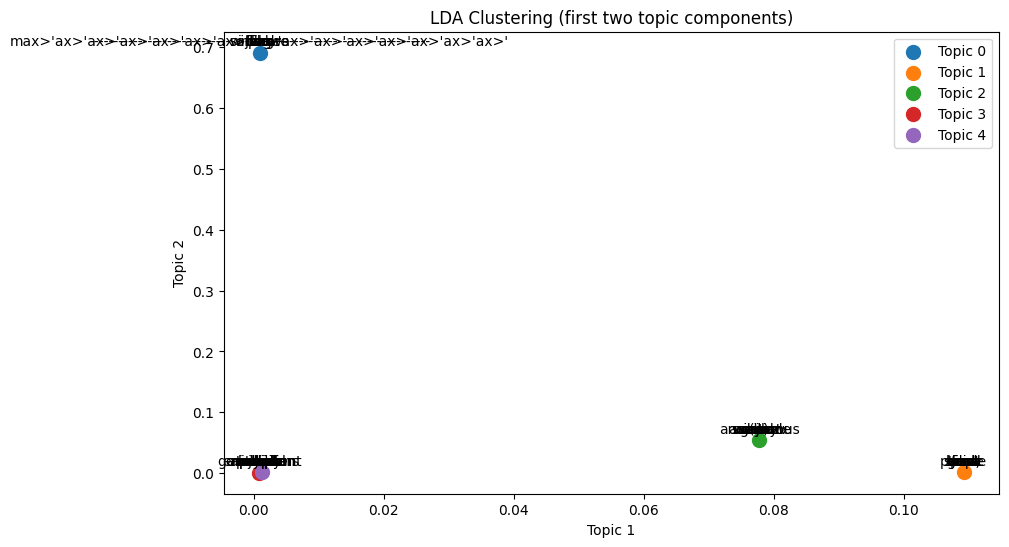

In [63]:
import matplotlib.pyplot as plt

# 1️⃣ Get top words for each topic
topics = model.describeTopics(10)
topic_words_indices = topics.select("termIndices").rdd.map(lambda row: row[0]).collect()
vocab = count_vec_model.vocabulary
topic_words_list = [[vocab[i] for i in indices] for indices in topic_words_indices]

# 2️⃣ Collect topic distributions for all documents
# Each row is a DenseVector of topic probabilities
distributions = transformed_data.select("topicDistribution").rdd.map(lambda row: row[0]).collect()

# 3️⃣ Plot using the first two components of topic distribution
plt.figure(figsize=(10, 6))

for i, words in enumerate(topic_words_list):
    # x = probability for topic 0, y = probability for topic 1
    x = distributions[i][1]
    y = distributions[i][2]
    plt.scatter(x, y, label=f"Topic {i}", s=100)
    
    # Annotate top words for this topic
    for word in words:
        plt.annotate(word, (x, y),
                     textcoords="offset points", xytext=(0, 5), ha="center")

plt.title("LDA Clustering (first two topic components)")
plt.xlabel("Topic 1")
plt.ylabel("Topic 2")
plt.legend()
plt.show()

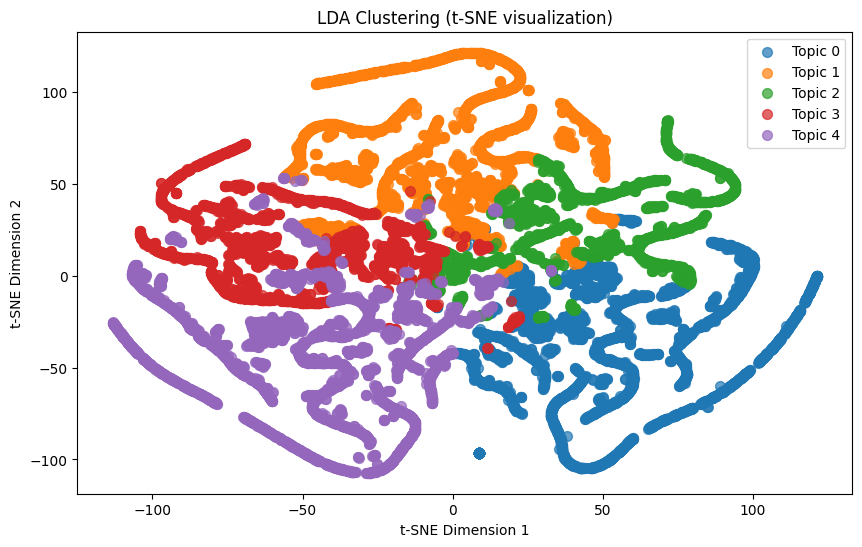

In [64]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 1️⃣ Collect topic distributions for all documents
# Each row is a DenseVector of topic probabilities
distributions = np.array(transformed_data.select("topicDistribution").rdd.map(lambda row: row[0].toArray()).collect())

# 2️⃣ Reduce dimensions to 2D with t-SNE
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_result = tsne_model.fit_transform(distributions)

# 3️⃣ Optional: Assign each document to its dominant topic
dominant_topics = np.argmax(distributions, axis=1)

# 4️⃣ Plot the documents colored by dominant topic
plt.figure(figsize=(10, 6))
num_topics = distributions.shape[1]

for topic in range(num_topics):
    idx = dominant_topics == topic
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=f"Topic {topic}", s=50, alpha=0.7)

plt.title("LDA Clustering (t-SNE visualization)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.show()
